# Assignment 1: Scalable Processing
## Yelp Reviews and Authenticity

Big Data Management | by Adam Hadou Temsamani (ahad) | ahad@itu.dk | 24/10/2025

## Connecting to the Spark Cluster job using the two JobParameters.json

To connect this jupyter notebook with your Spark cluster, we need to tell jupyter how it can access the spark cluster. Below code accomplishes that. Do not worry about how it works, just run the cell once to connect. 

In [1]:
#####################################################################
# DO NOT CHANGE ANYTHING HERE.
# IF YOU HAVE PROBLEMS, CHECK THE ASSIGNMENT GUIDE CAREFULLY 
#####################################################################
from IPython.display import Javascript, display
import jupyterlab
import os, json, pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.conf import SparkConf
from py4j.protocol import Py4JJavaError


def show_popup(message):
    display(Javascript(f'alert("{message}")'))

def check_correct_file_location():
    items = os.listdir('/work')
    items_expected = ['yelp', 'Home','JobParameters.json', 'emails']
    if sorted(items) != sorted(items_expected):
        items_to_be_moved = [item for item in items if item not in items_expected and item[0] != '.'] # Ignore hidden files starting with .
        show_popup(f"Warning: Found these files {items_to_be_moved} that should (most likely) be moved inside your Home folder. Make sure your Git repository and notebooks are all saved inside your Home folder and not at the 'root'/top of filesystem. Please move your files to prevent them from disappearing.")
    if 'emails' not in items_expected:
        show_popup(f'Error: the folder "emails" does not seem to be accessible - did you remeber to add it to the Spark Cluster job and JupyterLab job?')
    
check_correct_file_location()

SUPPORTED_SPARK_VERSION = "3.3.1"
SUPPORTED_JUPYTERLAB_VERSION = "3.5.1"
if jupyterlab.__version__ != SUPPORTED_JUPYTERLAB_VERSION:
    show_popup(f"Wrong JupyterLab version :( When starting the UCloud job you selected {jupyterlab.__version__} but it should have been {SUPPORTED_JUPYTERLAB_VERSION}")
    show_popup("Please shutdown this JupyterLab job and follow the instructions carefully in the UCloud setup guide PDF on LearnIT") 
elif '_EXECUTED_' in globals(): # Only execute this cell once.
    # check if variable '_EXECUTED_' exists in the global variable namespace
    print("Already been executed once, not running again!")
else:
    print("Cell has not been executed before. Please restart the UCloud jobs if any error message pops up. Running setup cell now.")
    # Two files are automatically read: JobParameters.json for the Spark Cluster job using a temporary spark instance
    # and JobParameters.json for the Jupyter Lab job to extract the hostname of the cluster. 

    MASTER_HOST_NAME = None

    # Open the parameters Jupyter Lab app was launched with
    with open('/work/JobParameters.json', 'r') as file:
        JUPYTER_LAB_JOB_PARAMS = json.load(file)
        # from pprint import pprint; pprint(JUPYTER_LAB_JOB_PARAMS) 
        for resource in JUPYTER_LAB_JOB_PARAMS['request']['resources']:
            if 'hostname' in resource.keys():
                MASTER_HOST_NAME = resource['hostname']
    
    if MASTER_HOST_NAME != "spark-cluster":
        msg = f"The JupyterLab job was started using spark hostname {MASTER_HOST_NAME}. This is not recommended, please start it using spark-cluster instead"
        show_popup(msg)
        print(msg)
    else:
        MASTER_HOST = f"spark://{MASTER_HOST_NAME}:7077"

        conf = SparkConf().setAll([
                ("spark.app.name", 'reading_job_params_app'), 
                ("spark.master", MASTER_HOST),
            ])

        spark = SparkSession.builder.config(conf=conf)\
                                    .getOrCreate()
        
        if spark.version != SUPPORTED_SPARK_VERSION:
            show_popup(f"Wrong Spark Cluster version :( When starting the UCloud job you selected {spark.version} but it should have been {SUPPORTED_SPARK_VERSION}")
            show_popup("Please shutdown this JupyterLab job, the Spark Cluster and follow the instructions carefully in the UCloud setup guide PDF on LearnIT") 

        CLUSTER_PARAMETERS_JSON_DF = spark.read.option("multiline","true").json('/work/JobParameters.json')
        
        # Extract cluster info from the specific JobParameters.json
        NODES = CLUSTER_PARAMETERS_JSON_DF.select("request.replicas").first()[0]
        CPUS_PER_NODE = CLUSTER_PARAMETERS_JSON_DF.select("machineType.cpu").first()[0] - 1
        MEM_PER_NODE = CLUSTER_PARAMETERS_JSON_DF.select("machineType.memoryInGigs").first()[0]

        CLUSTER_CORES_MAX = CPUS_PER_NODE * NODES
        CLUSTER_MEMORY_MAX = MEM_PER_NODE * NODES 
        
        if CPUS_PER_NODE > 1:
            EXECUTOR_CORES = CPUS_PER_NODE - 1  # set cores per executor on worker node
        else:
            EXECUTOR_CORES = CPUS_PER_NODE 

        try:
            EXECUTOR_MEMORY = int(
                MEM_PER_NODE / (CPUS_PER_NODE / EXECUTOR_CORES) * 0.5
            )  # set executor memory in GB on each worker node
        except ZeroDivisionError:
            show_popup(f"Please make sure you selected 3 nodes for the Spark Cluster, each with 24 GB of ram. You selected {MEM_PER_NODE} GB ram and {NODES} node(s)")
            
        # Make sure there is a dir for spark logs
        if not os.path.exists('spark_logs'):
            os.mkdir('spark_logs')

        conf = SparkConf().setAll(
            [
                ("spark.app.name", 'spark_assignment'), # Change to your liking 
                ("spark.sql.caseSensitive", False), # Optional: Make queries strings sensitive to captialization
                ("spark.master", MASTER_HOST),
                ("spark.cores.max", CLUSTER_CORES_MAX),
                ("spark.executor.cores", EXECUTOR_CORES),
                ("spark.executor.memory", str(EXECUTOR_MEMORY) + "g"),
                ("spark.eventLog.enabled", True),
                ("spark.eventLog.dir", "spark_logs"),
                ("spark.history.fs.logDirectory", "spark_logs"),
                ("spark.deploy.mode", "cluster"),
            ]
        )

        ## check executor memory, taking into accout 10% of memory overhead (minimum 384 MiB)
        CHECK = (CLUSTER_CORES_MAX / EXECUTOR_CORES) * (
            EXECUTOR_MEMORY + max(EXECUTOR_MEMORY * 0.10, 0.403)
        )

        assert (
            int(CHECK) <= CLUSTER_MEMORY_MAX
        ), "Executor memory larger than cluster total memory!"

        # Stop previous session that was just for loading cluster params
        spark.stop()

        # Start new session with above config, that has better resource handling
        spark = SparkSession.builder.config(conf=conf)\
                                    .getOrCreate()
        sc = spark.sparkContext
        _EXECUTED_ = True
        print("Success!")

<IPython.core.display.Javascript object>

Cell has not been executed before. Please restart the UCloud jobs if any error message pops up. Running setup cell now.
Success!


## Code for running the assignment locally
Ignore if running on UCloud

In [1]:
from IPython.display import Javascript, display
import jupyterlab
import os, json, pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.conf import SparkConf
from py4j.protocol import Py4JJavaError

spark = SparkSession.builder.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/05 10:06:10 WARN Utils: Your hostname, ADAM-GALAXYBOOK5PRO, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/05 10:06:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/05 10:06:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load the data
business = spark.read.json("datasets/yelp/yelp_academic_dataset_business.json")
users = spark.read.json("datasets/yelp/yelp_academic_dataset_user.json")
reviews = spark.read.json("datasets/yelp/yelp_academic_dataset_review.json")

# Downsample the data
#reviews = reviews.sample(withReplacement=False, fraction=5/50)
#reviews.cache()
reviews.count()

#users = users.sample(withReplacement=False, fraction=5/50)
#users.cache()
users.count()

#business = business.sample(withReplacement=False, fraction=5/50)
#business.cache()
business.count()

26/01/05 10:07:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


150346

Click on the "SparkMonitor" tab at the top in Jupyter Lab to see the status of running code on the cluster.

---

## Loading the data
Here we specify where the yelp datasets are located on UCloud and read then using the spark session.

In [4]:
# Read in the business and review files
# This is the path to the shared datasets provided by adding an the dataset input folder
# when submitting the spark cluster job.
business = spark.read.json('file:////work/yelp/yelp_academic_dataset_business.json') # Use the file:/// prefix to indicate we want to read from the cluster's filesystem
business = business.persist()
# Persist 2 commonly used dataframes since they're used for later computations
# https://sparkbyexamples.com/spark/spark-difference-between-cache-and-persist/

users = spark.read.json("file:////work/yelp/yelp_academic_dataset_user.json")

reviews = spark.read.json('file:////work/yelp/yelp_academic_dataset_review.json')
reviews = reviews.persist()

See assignment PDF for task descriptions.

---

### Task 3.1.1:

In [3]:
#Find the total number of reviews for all businesses.
print("Review count:", reviews.count())

Review count: 6990280


### Task 3.1.2:

In [7]:
# Find all businesses that have received 5 stars (on average: Use business.stars column)
# and that have been reviewed by 750 or more users. The output should be in the form of a
# DataFrame of (name, stars, review count).

five_stars_business = business.filter((business.stars == 5) & (business.review_count >= 750))\
                        .select("name", "stars", "review_count")
five_stars_business.show()
print("Number of businesses:", five_stars_business.count())

+------------------+-----+------------+
|              name|stars|review_count|
+------------------+-----+------------+
|   Blues City Deli|  5.0|         991|
|Free Tours By Foot|  5.0|         769|
|  Carlillos Cocina|  5.0|         799|
+------------------+-----+------------+

Number of businesses: 3


### Task 3.1.3: 

In [4]:
# Find influencers who have written more than 750 reviews. And have an average rating
# higher than 4 stars. The output should be in the form of a Spark Table/DataFrame of user
# id.

influencers = users.filter((users.review_count > 750) & (users.average_stars > 4))\
                .select("user_id")

print("Number of influencers:", influencers.count())
print("Number of users:", users.count())
influencers.show()

Number of influencers: 1028


Number of users: 1987897
+--------------------+
|             user_id|
+--------------------+
|MGPQVLsODMm9ZtYQW...|
|RgDVC3ZUBqpEe6Y1k...|
|VHdY6oG2JPVNjihWh...|
|UQFE3BT1rsIYrcDvu...|
|0G-QF457q_0Z_jKqh...|
|ITa3vh5ERI90G_WP4...|
|oW2bCSJ5bIHyRnoZv...|
|13f_vtUZEmlzweL91...|
|UVUIi0q38pAvsfuEE...|
|zDBOdWtl2PsNY38Ie...|
|7Na1pUcEv3oF_QTRw...|
|MUzkXfPS9JaMgJ907...|
|YWFbTcVnun8i03XnE...|
|Ve0LUwcrzxL7w0RYg...|
|i5Cm53q0pmklQsX8s...|
|IzJ36jX6V6ky5BtoN...|
|eTvp_hYnsrI5-ow_s...|
|7PHHxsjyk7I7oM6EN...|
|WWnhqRnWWjutMqh-2...|
|0QdwQLVxZpgy9Qb2Q...|
+--------------------+
only showing top 20 rows


### Task 3.1.4: 

In [6]:
# Find the businesses names and their average ratings for ones that have been reviewed by
# more than 5 influencer users. You can use a view created from your answer to Q3

influencers = users.filter((users.review_count > 750) & (users.average_stars > 4))\
                .select("user_id")

review_influencers = reviews.join(influencers, on="user_id", how="inner") \
                        .withColumnRenamed("stars", "review_stars") \
                        .select("business_id", "user_id", "review_stars")


business_review_influencers = business.join(review_influencers, on="business_id", how="inner")         

business_influence_rating = business_review_influencers.groupBy("business_id", "name")\
                    .agg(F.countDistinct("user_id").alias("influencer_count"), F.avg("review_stars").alias("average_rating"))

business_review_by_five = business_influence_rating.filter(business_influence_rating.influencer_count > 5)

business_review_by_five.select("name", "average_rating").show()
print("Count of businesses reviewed by more than five influencers:", business_review_by_five.count())



+--------------------+------------------+
|                name|    average_rating|
+--------------------+------------------+
|Tampa Premium Out...| 4.538461538461538|
|    Ryman Auditorium|4.7407407407407405|
|The Original Tony...|              4.32|
|  Adventure Aquarium|3.6666666666666665|
|              Homage| 4.583333333333333|
|John Seigenthaler...| 4.636363636363637|
|  Whole Foods Market| 4.333333333333333|
|St. James Cheese ...|               4.5|
|                Saba|               5.0|
| Mimi Blue Meatballs| 3.888888888888889|
|  Saints And Sinners|               4.0|
|           801 Royal|              4.25|
|         First Watch|3.8333333333333335|
|Stonehouse Restau...| 4.833333333333333|
|   Santa Barbara Zoo| 4.461538461538462|
|Busch Gardens Tam...|               4.0|
|Drunken Fish - Ce...|3.3333333333333335|
|              Target|               4.3|
|      The Small Mall|               4.5|
|         Metro Diner| 4.666666666666667|
+--------------------+------------

Count of businesses reviewed by more than five influencers: 2298


### Task 3.1.5: 

In [6]:
# Find an ordered list of users based on the average star counts they have given in all their
# reviews. 

user_avg_stars = reviews.groupBy("user_id") \
                    .agg(F.avg(F.col("stars")).alias("avg_stars"), F.count("*").alias("review_count")) 

user_avg_name = user_avg_stars.join(users.select("user_id", "name"), on="user_id", how="inner") # I don't join on all users, as I only want their names

user_avg_ordered = user_avg_name.orderBy(F.desc("avg_stars"),F.desc("review_count")) # I am assuming that I also need to all order it by their reivews (as secondary), as users with more reviews are more important

user_avg_ordered.show()
print("Count:", user_avg_ordered.count())


+--------------------+---------+------------+--------------+
|             user_id|avg_stars|review_count|          name|
+--------------------+---------+------------+--------------+
|7NHf3QgyGlZ_9pwdW...|      5.0|         231|       Carolyn|
|vOssX3-YwoP4DgdL7...|      5.0|         214|        Pinkie|
|rfFCDTjJMN7ChYcCK...|      5.0|         138|           Eve|
|Wxw5fFaT2b3-hZn1P...|      5.0|          91|       Timothy|
|rHGnUvQBIPPw-BYxQ...|      5.0|          89|Nicole Caridad|
|1wcZC44UwXcWPMyuJ...|      5.0|          70|           Tom|
|uyv47azu0RDhJLyWU...|      5.0|          64|        Denise|
|3fZeYZsNbMEUo198R...|      5.0|          63|          Paul|
|MB0jD-3_LUktXJPl3...|      5.0|          63|         Megan|
|I6x-ZBHeCNlMnmtfU...|      5.0|          60|          Jeff|
|uBW16OCkFKvzdezUK...|      5.0|          59|             T|
|FtNOuj0fwiggkIPrM...|      5.0|          59|    Carrington|
|QSPUE8emCtBgQ9P1w...|      5.0|          53|         Derek|
|T57CqtZK-Dc3vlnLb...|  

Count: 1987897


### Task 3.2.1: Data Exploration

In [8]:
# What is the percentage of reviews that contain a variant of the word "authentic", and do not contain "inauthentic". 

# Let's start by defining authentic and inauthentic words (i.e. synonyms):
authentic_words = ["authentic", "genuine", "legit", "real", "legitimate", "valid", "original", "credible"]
inauthentic_words = ["inauthentic", "unauthentic", "fake", "sham", "ungenuine", "unreal", "invalid", "unorginal", "illigitimate"]

# Create a helper regex pattern (case-insensitive)
authentic_pattern = "(?i)(" + "|".join(authentic_words) + ")"
inauthentic_pattern = "(?i)(" + "|".join(inauthentic_words) + ")"

# Include authentic and exclude the inauthentic
authentic_reviews = reviews.filter(F.col("text").rlike(authentic_pattern) & (~F.col("text").rlike(inauthentic_pattern)))

# Get percentage of reviews
total_reviews = reviews.count()
total_authentic_reviews = authentic_reviews.count()
percentage = total_authentic_reviews / total_reviews * 100

print("Total review count:", total_reviews)
print("Total authentic reviews count", total_authentic_reviews)
print("Percentage of reviews including authentic and excluding inauthentic:", percentage)


Total review count: 6990280
Total authentic reviews count 1648844
Percentage of reviews including authentic and excluding inauthentic: 23.587667446797553


In [65]:
# # How many reviews contain the string "genuine" grouped by businesses type?
from pyspark.sql import functions as F

# Filter reviews containing "genuine"
reviews_with_genuine = reviews.filter(F.col("text").rlike("(?i)genuine")).select("review_id", "business_id")

# Explode business categories
business_exploded = business.select("business_id", "categories") \
    .filter(F.col("categories").isNotNull()) \
    .withColumn("business_type", F.explode(F.split(F.col("categories"), ", "))) \
    .withColumn("business_type", F.trim(F.col("business_type"))) \
    .select("business_id", "business_type")


# Join reviews with business
rg_with_business = reviews_with_genuine.join(business_exploded, on="business_id", how="inner")

# Group by business type
rg_by_type = rg_with_business.groupBy("business_type") \
    .agg(F.count("*").alias("genuine_review_count")) \
    .orderBy(F.desc("genuine_review_count"))


# review count
rg_by_type.show(20, truncate=False)

# print("Total reviews with genuine:", total_result)


+-------------------------+--------------------+
|business_type            |genuine_review_count|
+-------------------------+--------------------+
|Restaurants              |18417               |
|Food                     |7529                |
|Nightlife                |5891                |
|Bars                     |5561                |
|American (New)           |4032                |
|American (Traditional)   |3739                |
|Shopping                 |3626                |
|Breakfast & Brunch       |3563                |
|Event Planning & Services|3105                |
|Beauty & Spas            |2978                |
|Health & Medical         |2902                |
|Sandwiches               |2850                |
|Seafood                  |2204                |
|Coffee & Tea             |2152                |
|Automotive               |1939                |
|Italian                  |1917                |
|Hotels & Travel          |1819                |
|Pizza              

In [9]:
# How many reviews contain the string "legitimate" grouped by type of cuisine?
# How about "illegitimate"?

resturants = business.select("business_id", "name", "categories") \
                                .filter(business.categories.rlike("(?i)restaurant")) \
                                .filter(F.col("categories").isNotNull()) 

resturants_exploded = resturants.withColumn("cuisine_type", F.explode(F.split(F.col("categories"), ", "))).select("business_id", "name", "cuisine_type")

# European Cuisine
european_cuisine = ["Italian", "French", "Spanish", "Greek", "Portuguese", "German", "Dutch", "Belgian", "Swiss", "Austrian", "Hungarian", "Polish", "Czech", "Slovak", "Danish", "Swedish", "Norwegian", "Finnish", "Icelandic"]
european_pattern = "(?i)(" + "|".join(european_cuisine) + ")"
european_cuisines = resturants_exploded.filter(F.col("cuisine_type").rlike(european_pattern))


# Asian Cuisine
asian_cuisine = ["Japanese", "Korean", "Chinese", "Thai", "Vietnamese", "Indian", "Malaysian", "Indonesian", "Filipino", "Singaporean", "Mongolian", "Cambodian", "Sri Lankan", "Nepalese", "Bangladeshi"]
asian_pattern = "(?i)(" + "|".join(asian_cuisine) + ")"
asian_cuisines = resturants_exploded.filter(F.col("cuisine_type").rlike(asian_pattern))

# Middle Eastern Cuisine
middle_eastern_cuisine = ["Palestenian", "Lebanese", "Turkish", "Persian", "Israeli", "Jordanian", "Syrian", "Iraqi", "Egyptian", "Saudi", "Emirati", "Kuwaiti", "Qatari", "Bahraini", "Omani", "Yemeni"]
middle_eastern_pattern = "(?i)(" + "|".join(middle_eastern_cuisine) + ")"
middle_eastern_cuisines = resturants_exploded.filter(F.col("cuisine_type").rlike(middle_eastern_pattern))

# African Cuisine
african_cuisine = ["Moroccan", "Ethiopian", "Tunisian", "Algerian", "Egyptian", "Nigerian", "Ghanaian", "South African", "Kenyan", "Tanzanian", "Ugandan", "Senegalese", "Cameroonian", "Ivorian"]
african_pattern = "(?i)(" + "|".join(african_cuisine) + ")"
african_cuisines = resturants_exploded.filter(F.col("cuisine_type").rlike(african_pattern))

# American Cuisine
american_cuisine = ["American", "Mexican", "Brazilian", "Argentinian", "Peruvian", "Colombian", "Chilean", "Cuban", "Puerto Rican", "Venezuelan", "Salvadoran", "Guatemalan", "Honduran", "Nicaraguan", "Costa Rican", "Panamanian"]
american_pattern = "(?i)(" + "|".join(american_cuisine) + ")"
american_cuisines = resturants_exploded.filter(F.col("cuisine_type").rlike(american_pattern))

# All Cuisine Types
all_cuisines = european_cuisines.union(asian_cuisines).union(middle_eastern_cuisines).union(african_cuisines).union(american_cuisines)

# Reviews that contain "legitimate" or "illegitimate"
legitimate_reviews = reviews.filter(F.col("text").rlike("(?i)legitimate"))
illegitimate_reviews = reviews.filter(F.col("text").rlike("(?i)illegitimate"))

# Join
legitimate_reviews_cuisines = all_cuisines.join(legitimate_reviews, on="business_id", how="inner")
illegitimate_reviews_cuisines = all_cuisines.join(illegitimate_reviews, on="business_id", how="inner")

# Group by cuisine type and count reviews
legitimate_count_by_cuisine = legitimate_reviews_cuisines.groupBy("cuisine_type") \
    .agg(F.count("*").alias("legitimate_count")) \
    .orderBy(F.desc("legitimate_count"))

illegitimate_count_by_cuisine = illegitimate_reviews_cuisines.groupBy("cuisine_type") \
    .agg(F.count("*").alias("illegitimate_count")) \
    .orderBy(F.desc("illegitimate_count"))

#How would i group this by cuisine? if categories is a string "Resturant, "Japanese", etc. 
#legitimate_count_by_cuisine.show(20, truncate=False)
illegitimate_count_by_cuisine.show(20, truncate=False)




+----------------------+------------------+
|cuisine_type          |illegitimate_count|
+----------------------+------------------+
|American (Traditional)|6                 |
|Mexican               |5                 |
|American (New)        |4                 |
|Italian               |3                 |
|Vietnamese            |2                 |
|Latin American        |1                 |
|Korean                |1                 |
|Cuban                 |1                 |
+----------------------+------------------+



26/01/05 11:50:21 WARN CacheManager: Asked to cache already cached data.


+-----+------------+------------------+-----------+------------------+
|state|city        |authenticity_count|total_count|percentage        |
+-----+------------+------------------+-----------+------------------+
|PA   |Philadelphia|270910            |967517     |28.000541592550825|
|TN   |Nashville   |112762            |451506     |24.974640425597887|
|IN   |Indianapolis|88885             |361489     |24.588576692513463|
|LA   |New Orleans |154657            |635329     |24.342820806227955|
|NV   |Reno        |84092             |351518     |23.92253028294426 |
|FL   |Tampa       |107293            |454833     |23.58953725873013 |
|AZ   |Tucson      |94897             |404865     |23.439171081718598|
+-----+------------+------------------+-----------+------------------+



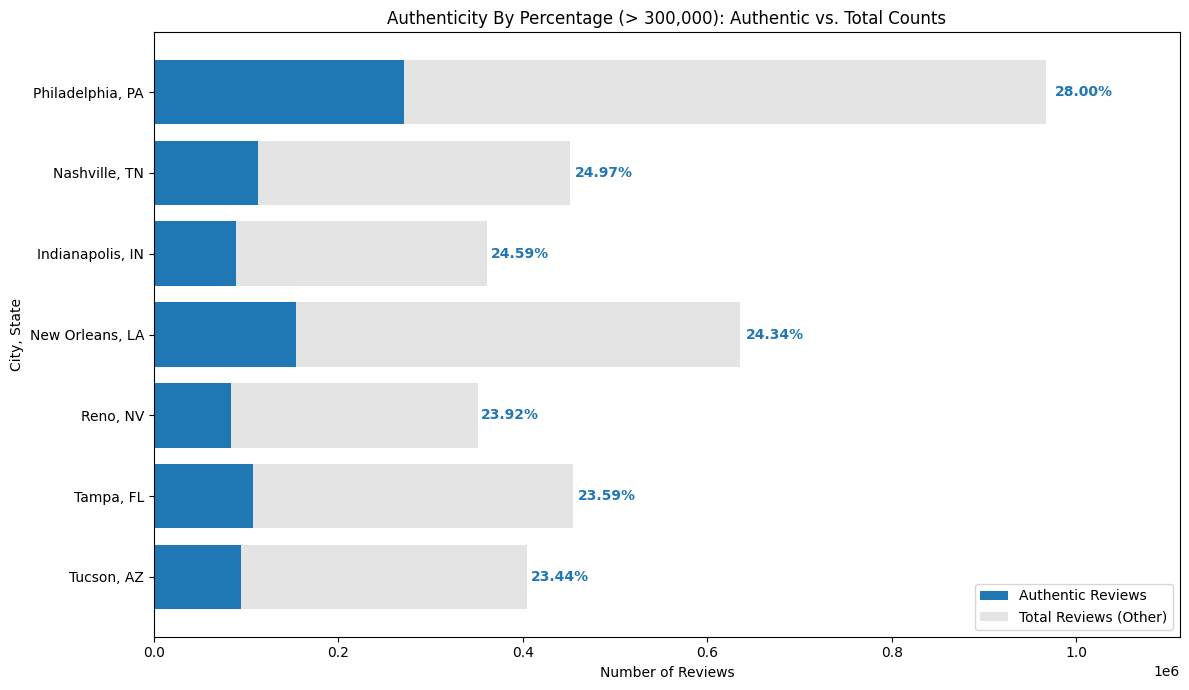

In [37]:
import matplotlib.pyplot as plt
# Is there a difference in the amount of authenticity language used in the different areas?
# (e.g., by state, north/south, urban/rural)
# Note: As part of answering this question, you could compute the full cube or rollup com-
# bining the location of the business and whether the review contains authenticity lan-
# guage, and use this to aggregate their counts per state and city.


# Why is cube rollup nice for this:
# It computes state and city totals in a single operation, allowing for direct Urban vs. Rural comparisons within the same dataset.
# You can easily "zoom out" to North vs. South or States by filtering city IS NULL

# Flag reviews with authenticity language
reviews_flagged = reviews.join(business.select("business_id", "state", "city"), "business_id") \
    .withColumn("has_authenticity", F.col("text").rlike("(?i)authentic|genuine|legit|real|legitimate|valid|original|credible").cast("int"))

# Full cube over state, city
cube_results = reviews_flagged.cube("state", "city") \
    .agg(
        F.sum("has_authenticity").alias("authenticity_count"),
        F.count("*").alias("total_count")
    ) \
    .withColumn("percentage", (F.col("authenticity_count") / F.col("total_count") * 100)) \
    .orderBy(F.desc("percentage")) # asc can also be used instead.

cube_filtered = cube_results.filter(F.col("state").isNotNull() & F.col("city").isNotNull())
cube_filtered.cache()
#cube_filtered.show(20, truncate=False)

cube_significant = cube_filtered.filter(F.col("total_count") > 300000).orderBy(F.desc("percentage"))
cube_significant.show(20, truncate=False)

# Plot

# 1. Convert to Pandas for visualization
pdf_urban = cube_significant.toPandas()

# 2. Calculate the 'non-authentic' portion and labels
pdf_urban['other_count'] = pdf_urban['total_count'] - pdf_urban['authenticity_count']
labels = [f"{row['city']}, {row['state']}" for _, row in pdf_urban.iterrows()]

# 3. Plotting
plt.figure(figsize=(12, 7))

# Plot 'Authentic' count
plt.barh(labels, pdf_urban['authenticity_count'], color='#1f77b4', label='Authentic Reviews')

# Stack 'Other' count
plt.barh(labels, pdf_urban['other_count'], left=pdf_urban['authenticity_count'], 
         color='#d3d3d3', label='Total Reviews (Other)', alpha=0.6)

# 4. Add Percentage Labels
for i, row in pdf_urban.reset_index(drop=True).iterrows():
    plt.text(row['total_count'] + (row['total_count'] * 0.01), i, 
             f"{row['percentage']:.2f}%", va='center', fontweight='bold', color='#1f77b4')

plt.title('Authenticity By Percentage (> 300,000): Authentic vs. Total Counts')
plt.xlabel('Number of Reviews')
plt.ylabel('City, State')
plt.legend(loc='lower right')
plt.xlim(0, pdf_urban['total_count'].max() * 1.15) # Space for labels
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('state_city_by_percentage.png')



#### State Comparison

26/01/05 11:50:50 WARN CacheManager: Asked to cache already cached data.
26/01/05 11:50:50 WARN CacheManager: Asked to cache already cached data.


Top 10 State, without filter:
+-----+------------------+-----------+------------------+
|state|authenticity_count|total_count|percentage        |
+-----+------------------+-----------+------------------+
|MT   |3                 |6          |50.0              |
|HI   |14                |34         |41.17647058823529 |
|CO   |12                |31         |38.70967741935484 |
|UT   |7                 |19         |36.84210526315789 |
|SD   |13                |42         |30.952380952380953|
+-----+------------------+-----------+------------------+
only showing top 5 rows
Top 10 States, with filter:
+-----+-----------+------------------+
|state|total_count|percentage        |
+-----+-----------+------------------+
|AB   |109436     |30.48448408202054 |
|PA   |1598960    |26.051621053684894|
|CA   |348856     |24.743733804205746|
|MO   |502385     |24.71112791982245 |
|TN   |614388     |24.135074252752332|
|LA   |761673     |23.967109245043478|
|IN   |489752     |23.95600222153253 |
|NV   

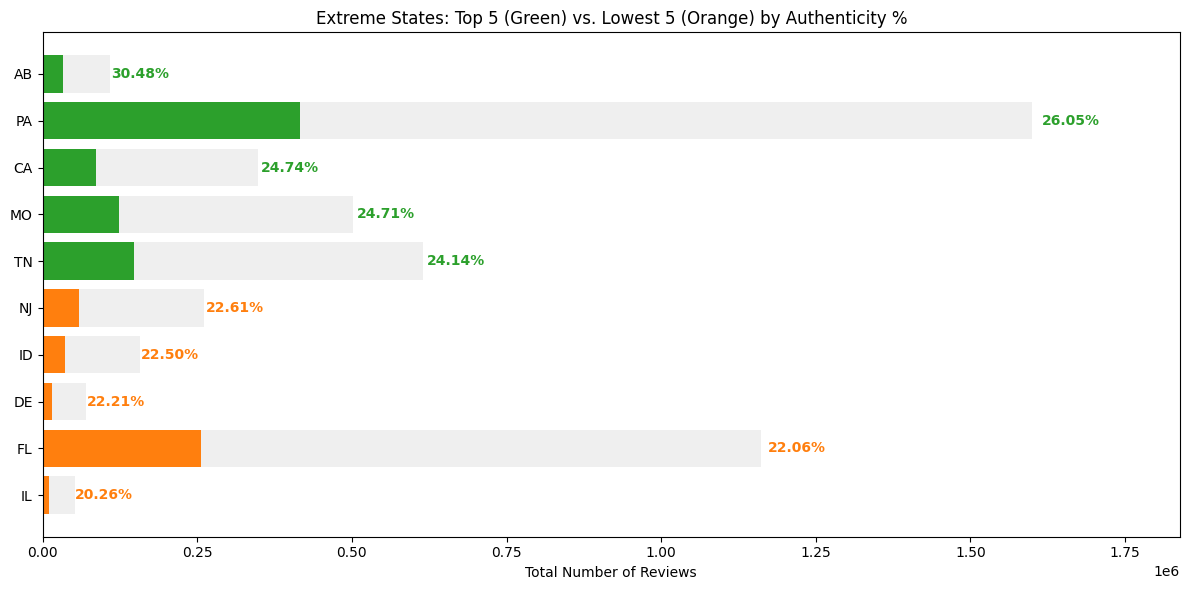

In [38]:
state_rankings = cube_results.filter(F.col("state").isNotNull() & F.col("city").isNull()) \
    .orderBy(F.desc("percentage"))
state_rankings.cache()

# Without filtering for reviews
print("Top 10 State, without filter:")
state_rankings.select("state", "authenticity_count", "total_count", "percentage").show(5, truncate=False)

state_totals = cube_results.filter(
    (F.col("state").isNotNull()) & 
    (F.col("city").isNull()) & 
    (F.col("total_count") > 1000)
)
state_totals.cache()

print("Top 10 States, with filter:")
state_totals.orderBy(F.desc("percentage")) \
    .select("state", "total_count", "percentage").show(10, truncate=False)

# Lowest 10 States by authenticity percentage
print("Lowest 10 States, with filter::")
state_totals.orderBy(F.asc("percentage")) \
    .select("state", "total_count", "percentage").show(10, truncate=False)


# Plot

# 1. Get extremes and sort
top_5 = state_totals.orderBy(F.desc("percentage")).limit(5)
bot_5 = state_totals.orderBy(F.asc("percentage")).limit(5)
pdf_extremes = top_5.union(bot_5).toPandas()
pdf_extremes = pdf_extremes.sort_values(by="percentage", ascending=True)

# 2. Assign colors: Coral for the Bottom 5, Green for the Top 5
# Since it is sorted ascending, the first 5 are Bottom, last 5 are Top
colors = ['#ff7f0e'] * 5 + ['#2ca02c'] * 5
pdf_extremes['other_count'] = pdf_extremes['total_count'] - pdf_extremes['authenticity_count']

# 3. Plot
plt.figure(figsize=(12, 6))
bars_auth = plt.barh(pdf_extremes['state'], pdf_extremes['authenticity_count'], color=colors)
bars_total = plt.barh(pdf_extremes['state'], pdf_extremes['other_count'], 
                     left=pdf_extremes['authenticity_count'], color='#e0e0e0', alpha=0.5)

# 4. Annotate percentages
for i, row in pdf_extremes.reset_index(drop=True).iterrows():
    color = '#ff7f0e' if i < 5 else '#2ca02c'
    plt.text(row['total_count'] + (row['total_count'] * 0.01), i, 
             f"{row['percentage']:.2f}%", va='center', fontweight='bold', color=color)

plt.title('Extreme States: Top 5 (Green) vs. Lowest 5 (Orange) by Authenticity %')
plt.xlabel('Total Number of Reviews')
plt.xlim(0, pdf_extremes['total_count'].max() * 1.15)
plt.tight_layout()
plt.savefig('state_top_bottom_5_by_percentage.png')

#### Rural/Urban Comparison

In [ ]:
area_comparison = cube_filtered.select("authenticity_count", "total_count") \
    .withColumn("area_type", 
        F.when(F.col("total_count") > 50000, "Urban")
         .otherwise("Rural/Suburban")
    )

area_comparison.groupBy("area_type") \
    .agg(F.sum("authenticity_count"), F.sum("total_count")) \
    .withColumn("percentage", (F.col("sum(authenticity_count)") / F.col("sum(total_count)") * 100)) \
    .show()

# What are the issues with this?
# Arbitrary THreshold of 50000



+--------------+-----------------------+----------------+------------------+
|     area_type|sum(authenticity_count)|sum(total_count)|        percentage|
+--------------+-----------------------+----------------+------------------+
|Rural/Suburban|                 477387|         2154649| 22.15613772823323|
|         Urban|                1209849|         4835631|25.019464884727554|
+--------------+-----------------------+----------------+------------------+



#### North/South

In [ ]:
north_states = ['PA', 'IL', 'WI', 'OH', 'AB', 'ON', 'QC', 'NJ', 'DE', 'MD', 'MA', 'MI', 'IN', 'ID', 'MT', 'OR', 'WA', 'MO'] 
south_states = ['FL', 'TN', 'LA', 'AZ', 'NV', 'NC', 'SC', 'GA', 'TX', 'AR', 'MS', 'AL', 'CA', 'UT', 'NM']

regional_comparison = cube_results.filter(F.col("city").isNull() & F.col("state").isNotNull()) \
    .withColumn("region", 
        F.when(F.col("state").isin(north_states), "North/Canada")
         .when(F.col("state").isin(south_states), "South/West")
         .otherwise("Other")
    )

regional_comparison.groupBy("region") \
    .agg(F.sum("authenticity_count"), F.sum("total_count")) \
    .withColumn("Percentage", (F.col("sum(authenticity_count)") / F.col("sum(total_count)") * 100)) \
    .show()

# Discussion: 
# A binary split might not give the most accurate data because.


+------------+-----------------------+----------------+------------------+
|      region|sum(authenticity_count)|sum(total_count)|        Percentage|
+------------+-----------------------+----------------+------------------+
|North/Canada|                 811956|         3241216|25.050968525392943|
|  South/West|                 875236|         3748931| 23.34628191343079|
|       Other|                     44|             133| 33.08270676691729|
+------------+-----------------------+----------------+------------------+



### Task 3.2.2: Hypothesis Testing

In [75]:
# Can you identify a difference in the relationship between authenticity language and 
# typically negative words, in restaurants serving South American or Asian cuisine compared
# to restaurants serving European cuisine? And to what degree? Can you think of any other
# categories you can compare in the context of the study?.

# Filter to only restaurants and explode cuisine types
resturants = business.select("business_id", "name", "categories") \
                                .filter(business.categories.rlike("(?i)restaurant")) \
                                .filter(F.col("categories").isNotNull())
resturants_exploded = resturants.withColumn("cuisine_type", F.explode(F.split(F.col("categories"), ", "))).select("business_id", "name", "cuisine_type")

# Patterns for authenticity and negative words
authenticity_words = ["authentic", "genuine", "legit", "real", "legitimate", "valid", "original", "credible"]
negative_words = ["bad", "terrible", "awful", "worst", "poor", "disappointing", "horrible", "dreadful", "lousy", "unpleasant"]

authentic_pattern = "(?i)(" + "|".join(authenticity_words) + ")"
negative_pattern = "(?i)(" + "|".join(negative_words) + ")"

# Cuisines (South American, Asian, European)
south_american_cuisine = ["Brazilian", "Argentinian", "Peruvian", "Colombian", "Chilean", "Cuban", "Puerto Rican", "Venezuelan", "Guatemalan", "Costa Rican"]
asian_cuisine = ["Japanese", "Korean", "Chinese", "Thai", "Vietnamese", "Indian", "Malaysian", "Indonesian", "Filipino", "Mongolian", "Sri Lankan", "Nepalese"]
european_cuisine = ["Italian", "French", "Spanish", "Greek", "Portuguese", "German", "Dutch", "Belgian", "Swiss", "Austrian", "Hungarian", "Polish", "Czech", "Danish", "Swedish", "Norwegian", "Finnish"]

south_american_pattern = "(?i)(" + "|".join(south_american_cuisine) + ")"
asian_pattern = "(?i)(" + "|".join(asian_cuisine) + ")"
european_pattern = "(?i)(" + "|".join(european_cuisine) + ")"

# Join reciews to get only those with relevant cuisine types
reviews_contain_authenticity_negativity = reviews.join(resturants_exploded.select("business_id","cuisine_type"), on="business_id", how="inner") \
    .withColumn("cuisine_group",
        F.when(F.col("cuisine_type").rlike(south_american_pattern), "South American")
         .when(F.col("cuisine_type").rlike(asian_pattern), "Asian")
         .when(F.col("cuisine_type").rlike(european_pattern), "European")
         .otherwise(None)) \
    .filter(F.col("cuisine_group").isNotNull()) \
    .withColumn("has_authenticity", F.col("text").rlike(authentic_pattern).cast("int")) \
    .withColumn("has_negative", F.col("text").rlike(negative_pattern).cast("int"))

authenticity_negativity_reduced = reviews_contain_authenticity_negativity.select("cuisine_group", "has_authenticity", "has_negative", "stars")

#authenticity_negativity_reduced.show()

authenticity_negativity_stars_by_region = (authenticity_negativity_reduced.withColumn("region_group",                                                               
    F.when(F.col("cuisine_group").isin("South American", "Asian"), "South American/Asian").otherwise("European"))
                                           
    .withColumn("star_group",
        F.when(F.col("stars") < 3, "Low Stars").when(F.col("stars") > 3, "High Stars").otherwise("Neutral Stars"))
                                           
    .groupBy("region_group", "star_group")
        .agg(
            F.count("*").alias("total_count"),
            F.sum("has_authenticity").alias("authenticity_count"),
            F.sum("has_negative").alias("negativity_count"),
            F.sum(F.when((F.col("has_authenticity") == 1) & (F.col("has_negative") == 1), 1).otherwise(0)
        ).alias("both_count"))
                                           
    .withColumn("authenticity_percentage", F.round(100.0 * F.col("authenticity_count") / F.col("total_count"), 3))
    .withColumn("negativity_percentage", F.round(100.0 * F.col("negativity_count") / F.col("total_count"), 3))
    .withColumn("both_percentage", F.round(100.0 * F.col("both_count") / F.col("total_count"), 3))
                                           
    .orderBy("region_group", "star_group")
    .select("region_group", "star_group", "authenticity_percentage", "negativity_percentage", "both_percentage")
)

authenticity_negativity_stars_by_region.show()


+--------------------+-------------+-----------------------+---------------------+---------------+
|        region_group|   star_group|authenticity_percentage|negativity_percentage|both_percentage|
+--------------------+-------------+-----------------------+---------------------+---------------+
|            European|   High Stars|                 26.057|                5.103|           1.93|
|            European|    Low Stars|                 23.639|               42.468|         11.423|
|            European|Neutral Stars|                 30.766|               21.813|          8.289|
|South American/Asian|   High Stars|                 27.386|                5.284|          2.044|
|South American/Asian|    Low Stars|                 24.643|               43.085|         11.695|
|South American/Asian|Neutral Stars|                  31.73|               21.772|          8.504|
+--------------------+-------------+-----------------------+---------------------+---------------+



### Task 3.3: Building a Rating Prediction Model

In [14]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [15]:
# Multiclass classification 
# Three classes: 1-2 stars, 3 stars, 4-5 stars (low, neutral, high)

# Load reviews from resturants only
resturants = business.select("business_id", "name", "categories", "stars").filter(business.categories.rlike("(?i)restaurant"))

# However reviews also has stars column, so we have to the business stars column
resturants = resturants.withColumnRenamed("stars", "business_stars")
reviews_resturants = reviews.join(resturants, on="business_id", how="inner")

# Remove all columns that are not important
reduced_reviews_resturants = reviews_resturants.select("business_id", "text", "stars", "business_stars")

# Label the reviews based on their stars
reviews_stars_labeled = reduced_reviews_resturants.withColumn("rating_label", \
    F.when(F.col("stars") <= 2, F.lit(0.0)).when(F.col("stars") == 3, F.lit(1.0)).when(F.col("stars") >= 4, F.lit(2.0))) \
    .withColumn("rating_label", F.col("rating_label").cast(DoubleType()))
    
reviews_stars_labeled.show(20)

+--------------------+--------------------+-----+--------------+------------+
|         business_id|                text|stars|business_stars|rating_label|
+--------------------+--------------------+-----+--------------+------------+
|XQfwVwDr-v0ZS3_Cb...|If you decide to ...|  3.0|           3.0|         1.0|
|YjUWPpI6HXG530lwP...|Family diner. Had...|  3.0|           3.5|         1.0|
|kxX2SOes4o-D3ZQBk...|Wow!  Yummy, diff...|  5.0|           4.0|         2.0|
|e4Vwtrqf-wpJfwesg...|Cute interior and...|  4.0|           4.0|         2.0|
|04UD14gamNjLY0IDY...|I am a long term ...|  1.0|           4.0|         0.0|
|LHSTtnW3YHCeUkRDG...|Amazingly amazing...|  5.0|           3.5|         2.0|
|gebiRewfieSdtt17P...|Had a party of 6 ...|  3.0|           3.5|         1.0|
|EQ-TZ2eeD_E0BHuvo...|Locals recommende...|  4.0|           4.0|         2.0|
|lj-E32x9_FA7GmUrB...|Love going here f...|  4.0|           3.5|         2.0|
|RZtGWDLCAtuipwaZ-...|Good food--loved ...|  4.0|           3.5|

In [16]:
# Clean the data and preprocess
processed_reviews = reviews_stars_labeled.withColumn("text", F.regexp_replace(F.col("text"), "[^a-zA-Z0-9\\s]", "")) \
    .withColumn("text", F.lower(F.col("text"))) \
    .withColumn("review_stars", F.col("stars").cast(DoubleType())) \
    .withColumn("business_stars", F.col("business_stars").cast(DoubleType())) 

processed_reviews.show()

+--------------------+--------------------+-----+--------------+------------+------------+
|         business_id|                text|stars|business_stars|rating_label|review_stars|
+--------------------+--------------------+-----+--------------+------------+------------+
|XQfwVwDr-v0ZS3_Cb...|if you decide to ...|  3.0|           3.0|         1.0|         3.0|
|YjUWPpI6HXG530lwP...|family diner had ...|  3.0|           3.5|         1.0|         3.0|
|kxX2SOes4o-D3ZQBk...|wow  yummy differ...|  5.0|           4.0|         2.0|         5.0|
|e4Vwtrqf-wpJfwesg...|cute interior and...|  4.0|           4.0|         2.0|         4.0|
|04UD14gamNjLY0IDY...|i am a long term ...|  1.0|           4.0|         0.0|         1.0|
|LHSTtnW3YHCeUkRDG...|amazingly amazing...|  5.0|           3.5|         2.0|         5.0|
|gebiRewfieSdtt17P...|had a party of 6 ...|  3.0|           3.5|         1.0|         3.0|
|EQ-TZ2eeD_E0BHuvo...|locals recommende...|  4.0|           4.0|         2.0|         4.0|

In [17]:
# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = processed_reviews.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from functools import reduce

# Balancing
low_test = train_data.filter(train_data.rating_label == 0.0).count()
neutral_test = train_data.filter(train_data.rating_label == 1.0).count()
high_test = train_data.filter(train_data.rating_label == 2.0).count()
target = int(min(low_test, neutral_test, high_test))
seed = 42

parts = []
for label, count in [(0.0, low_test), (1.0, neutral_test), (2.0, high_test)]:
    df_label = train_data.filter(F.col("rating_label") == label)
    if count > target:
        frac = float(target) / float(count)
        sampled = df_label.sample(withReplacement=False, fraction=frac, seed=seed)
    else:
        sampled = df_label
    parts.append(sampled)

trained_balanced = reduce(lambda a, b: a.union(b), parts).cache() # Cache for faster access

In [95]:
# Feature extraction, using TF-IDF
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol="rating_label", maxIter=20)

# Pipeline
pipeline_tfidf = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])
model_tfidf = pipeline_tfidf.fit(trained_balanced)
predictions_tfidf = model_tfidf.transform(test_data)

In [97]:
# Evaluate the model
evaluator_acc = MulticlassClassificationEvaluator(labelCol="rating_label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="rating_label", predictionCol="prediction", metricName="f1")

accuracy_tfidf = evaluator_acc.evaluate(predictions_tfidf)
f1_tfidf = evaluator_f1.evaluate(predictions_tfidf)

print(f"TF-IDF Model Accuracy: {accuracy_tfidf:.4f}")
print(f"TF-IDF Model F1 score: {f1_tfidf:.4f}")

TF-IDF Model Accuracy: 0.8184
TF-IDF Model F1 score: 0.8353


In [100]:
from pyspark.sql import Row

# Example new reviews
example_reviews = [
    Row(text="The food was really good and the staff were very friendly to me"),
    Row(text="The food was okay, nothing special but not terrible"),
    Row(text="The food was very great, but the service was terrible"),
    Row(text="Horrible service, my order took way too long and was even wrong"),
]

example_df = spark.createDataFrame(example_reviews)

predictions_tfidf = model_tfidf.transform(example_df)
predictions_tfidf.select("text", "prediction").show(truncate=False)

+---------------------------------------------------------------+----------+
|text                                                           |prediction|
+---------------------------------------------------------------+----------+
|The food was really good and the staff were very friendly to me|2.0       |
|The food was okay, nothing special but not terrible            |0.0       |
|The food was very great, but the service was terrible          |0.0       |
|Horrible service, my order took way too long and was even wrong|0.0       |
+---------------------------------------------------------------+----------+

